In [2]:
from benchmark import Benchmark
from quantum import H_from_qubo, Qobj
from MaxCut import MaxCut

from qaoa_and_tdvp import QAOA, QAOAResult, qaoa_tdvp_rhs

import pickle

import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple, Union, Optional, Callable, Any
import networkx as nx
import matplotlib.pyplot as plt
import plotly as py

import pandas as pd

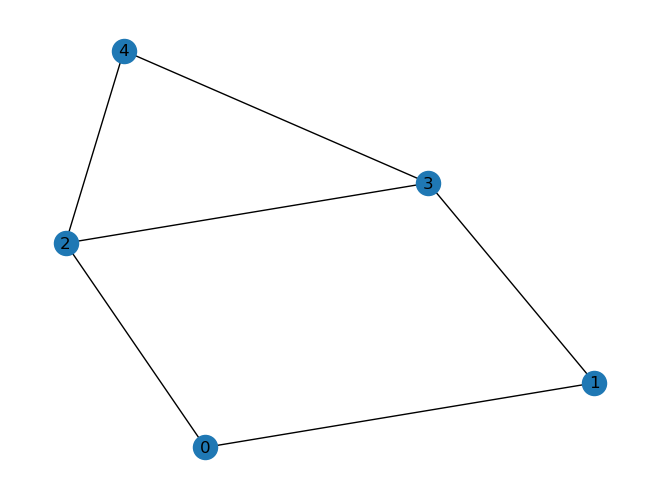

In [8]:
instance = MaxCut(nx.house_graph())
qaoa = QAOA(instance.qubo, p=1)
delta = tuple(1 for _ in range(2 * qaoa.p))
bench = Benchmark()

In [9]:
for p in range(1, 6):
    bench.run(
    qaoa=qaoa,
    delta_0=tuple(1 for _ in range(2 * p)),
    p=p,
    tdvp_stepsize=10,
    tdvp_grad_tol=1e-3,
    tdvp_lineq_solver="RK45",
    )
bench.save("RK45_p_1-6_grad_tol_1e-5")

rhs step 88
 done


In [ ]:
df = pd.DataFrame()
for exp in bench.results:
    df["p"].append(exp["p"])
    df["tdvp: number of gates"].append(exp["tdvp"].num_gates)
    df["scipy: number of gates"].append(exp["scipy"].num_gates)
    df["tdvp: ground state overlap"].append(exp["tdvp"].overlap)
    df["scipy: ground state overlap"].append(exp["scipy"].overlap)
    df["scipy: expectation value"].append(exp["scipy"].value)
    df["tdvp: expectation value"].append(exp["tdvp"].value)

In [ ]:
py.express.dataframe.scatter(df, x="p", y=["tdvp: number of gates", "scipy: number of gates"])